# Problem Set 3
## Nora Nickels
### Perspectives of Computational Analysis
### Winter 2018

In [68]:
# Import packages and load the data
%matplotlib inline
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pandas as pd
cmap1 = matplotlib.cm.get_cmap('summer')
# This next command is specifically for Jupyter Notebook
%matplotlib notebook

## Problem 1: Some income data, lognormal distribution, and GMM

In [11]:
# Load data
incomes = np.loadtxt('incomes.txt')

### a. Plot histogram 

<IPython.core.display.Javascript object>


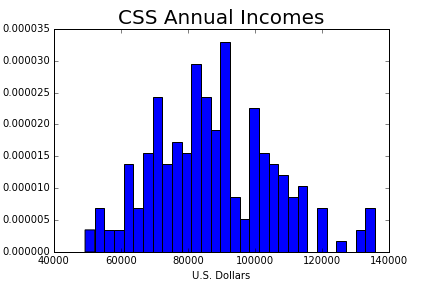

In [21]:
# a. Plot histogram 
plt.figure()
plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('CSS Annual Incomes', fontsize=20)
plt.xlabel('U.S. Dollars')
plt.ylabel('Percent of Income Observations')

### b. GMM

In [13]:
# b. GMM
# Define function that generates values of a potentially lognormal
# probability density function (PDF)
def lognorm_pdf(xvals, mu, sigma, cutoff):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the truncated normal pdf with mean mu and
    standard deviation sigma. If the cutoff is finite, then the PDF
    values are inflated upward to reflect the zero probability on values
    above the cutoff. If there is no cutoff given or if it is given as
    infinity, this function does the same thing as
    sp.stats.norm.pdf(x, loc=mu, scale=sigma).
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    prob_notcut = scalar 
    pdf_vals = (N,) vector, normal PDF values for mu and sigma
               corresponding to xvals data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''
    if cutoff == 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(0, loc=mu, s=sigma, scale=1)
    else:
        prob_notcut = (sts.lognorm.cdf(cutoff, loc=mu, s=sigma, scale=1) -
                       sts.lognorm.cdf(0, loc=mu, s=sigma, scale=1))
            
    pdf_vals    = ((1/(xvals * sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

In [14]:
# Define a criterion function that takes as inputs the parameters and the estimator for the weighting matrix Ŵ 

# Defining data moments - data mean and SD
def data_moments(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for GMM
    (mean(data), variance(data)).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data = scalar, mean value of test scores data
    var_data  = scalar > 0, variance of test scores data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_data, var_data
    --------------------------------------------------------------------
    '''
    mean_data = xvals.mean()
    std_data = xvals.std()
    
    return mean_data, std_data


# Defining model moments - model mean and SD
def model_moments(mu, sigma, cutoff):
    '''
    --------------------------------------------------------------------
    This function computes the two model moments for GMM
    (mean(model data), variance(model data)).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        trunc_norm_pdf()
        xfx()
        x2fx()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_model = scalar, mean value of test scores from model
    m_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the mean of the distribution
    var_model  = scalar > 0, variance of test scores from model
    v_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the variance of the distribution
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_model, var_model
    --------------------------------------------------------------------
    '''
    xfx = lambda x: x * lognorm_pdf(x, mu, sigma, cutoff)
    (mean_model, m_m_err) = intgr.quad(xfx, 0.01, cutoff)
    x2fx = lambda x: ((x - mean_model) ** 2) * lognorm_pdf(x, mu, sigma, cutoff) 
    (var_model, v_m_err) = intgr.quad(x2fx, 0.01, cutoff)
    std_model = np.sqrt(var_model)
    return mean_model, std_model
# Make sure to cutoff values to be positive, and define std instead of just variance.


# Defining error
def err_vec(xvals, mu, sigma, cutoff, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments()
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma, cutoff)
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


# Define criterion function, identity weighting
def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        norm_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (2, 1) matrix, column vector of two moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [15]:
# Ok starting the estimation. Using values from pset 2 for initial mean and std
# Note that this takes a little time because the intgr.quad() commands
# are a little slow

mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (incomes, 150000, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
# print crit value too
GMM1_crit_value = criterion(params_init, *gmm_args)[0][0]
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1, "crit value=", GMM1_crit_value)

mu_GMM1= 11.3660505197  sig_GMM1= 0.208759131345 crit value= 0.396870224136


In [16]:
# Report and compare two data moments against two model moments.

mean_data, std_data = data_moments(incomes)
mean_model, std_model = model_moments(mu_GMM1, sig_GMM1, 150000)
err1 = err_vec(incomes, mu_GMM1, sig_GMM1, 150000, False).reshape(2,)
print('Mean of points =', mean_data, ', Std of points =', std_data)
print('Mean of model =', mean_model, ', Std of model =', std_model)
print('Error vector=', err1)
results

Mean of points = 87588.9307685 , Std of points = 18035.9068271
Mean of model = 87588.9096624813 , Std of model = 18035.9041759
Error vector= [ -2.40966877e-07  -1.46996415e-07]


      fun: array([[  7.96729818e-14]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -6.17012253e-07,  -1.00771870e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 51
      nit: 10
   status: 0
  success: True
        x: array([ 11.36605052,   0.20875913])

<IPython.core.display.Javascript object>


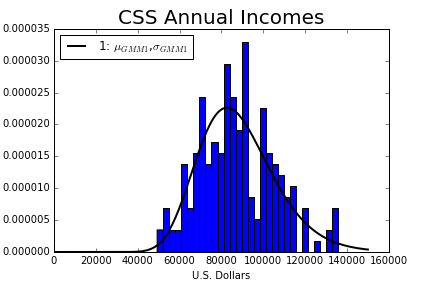

In [66]:
# Plot PDF against histogram of the data

# Plot the histogram of the data
plt.figure()
plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('CSS Annual Incomes', fontsize=20)
plt.xlabel('U.S. Dollars')
plt.ylabel('Percent of Income Observations')

# Plot the estimated GMM PDF
dist_incomes = np.linspace(1e-10, 150000, 200)
plt.plot(dist_incomes, lognorm_pdf(dist_incomes, mu_GMM1, sig_GMM1, 'None'),
         linewidth=2, color='k', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')

### c. two-step GMM estimator

In [23]:
# this problem set has been so much more enjoyable than pset 2 I must say. phew. ok focus.

# use dist_incomes to limit
err1 = err_vec(dist_incomes, mu_GMM1, sig_GMM1, 150000, False)
VCV2 = np.dot(err1, err1.T) / dist_incomes.shape[0]
print(VCV2)
W_hat2 = lin.pinv(VCV2)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print(W_hat2)

[[ 0.00014087 -0.00049143]
 [-0.00049143  0.00171438]]
[[  40.92778814 -142.7775422 ]
 [-142.7775422   498.08278149]]


In [26]:
# Estimate new GMM estimator
params_init2step = np.array([mu_GMM1, sig_GMM1])
# W_hat3 = np.array([[1. / VCV2[0, 0], 0.], [0., 1. / VCV2[1, 1]]])
gmm_args2step = (incomes, 150000, W_hat2)
results2step = opt.minimize(criterion, params_init2step, args=(gmm_args2step),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results2step.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)

mu_GMM2= 11.3660505215  sig_GMM2= 0.208759145013


<IPython.core.display.Javascript object>


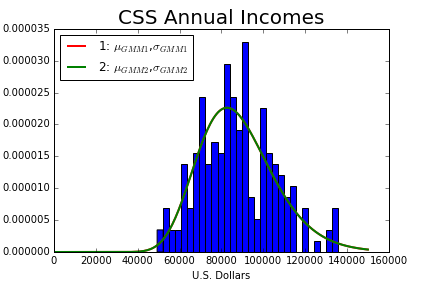

In [30]:
# plot estimated lognormal pdf against histogram from part a and b

# Plot the histogram of the data
plt.figure()
plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('CSS Annual Incomes', fontsize=20)
plt.xlabel('U.S. Dollars')
plt.ylabel('Percent of Income Observations')

# Plot the estimated GMM PDF for b and c together
dist_incomes = np.linspace(1e-10, 150000, 200)
plt.plot(dist_incomes, lognorm_pdf(dist_incomes, mu_GMM1, sig_GMM1, 'None'),
         linewidth=2, color='r', label='1: $\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.plot(dist_incomes, lognorm_pdf(dist_incomes, mu_GMM2, sig_GMM2, 'None'),
         linewidth=2, color='g', label='2: $\mu_{GMM2}$,$\sigma_{GMM2}$')
plt.legend(loc='upper left')

In [28]:
# those are the same basically as before, so the parts b and c lines overlap each other.

# compare crit values, data moments, and model moments
params_2step = np.array([mu_GMM2, sig_GMM2])
GMM2step_crit_value = criterion(params_2step, *gmm_args2step)[0][0]
mean_data, std_data = data_moments(incomes)
mean_model2, std_model2 = model_moments(mu_GMM2, sig_GMM2, 150000)
err1 = err_vec(incomes, mu_GMM2, sig_GMM2, 150000, False).reshape(2,)
print('Mean of points =', mean_data, ', Std of points =', std_data)
print('Mean of model2 =', mean_model2, ', Std of model2 =', std_model2)
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2, "crit value2=", GMM2step_crit_value)


Mean of points = 87588.9307685 , Std of points = 18035.9068271
Mean of model2 = 87588.90971478095 , Std of model2 = 18035.9052146
mu_GMM2= 11.3660505215  sig_GMM2= 0.208759145013 crit value2= 2.09338262605e-13


### d. using different moments

In [33]:
# ok using three new moments.

def data_moments3(xvals):
    
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = (xvals[xvals > 100000].shape[0] /
                  xvals.shape[0])

    return bpct_1_dat, bpct_2_dat, bpct_3_dat


def model_moments3(mu, sigma, cutoff):
    
    xfx = lambda x: lognorm_pdf(x, mu, sigma, cutoff)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0.01, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 150000)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod


def err_vec3(xvals, mu, sigma, cutoff, simple):
    
    bpct_1_dat, bpct_2_dat, bpct_3_dat = \
        data_moments3(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = \
        model_moments3(mu, sigma, cutoff)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]
                          ])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    
    return err_vec


def criterion3(params, *args):
    
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec3(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [35]:
mu_init3 = 11
sig_init3 = 5
params_init3 = np.array([mu_init3, sig_init3])
W_hat = np.eye(3)

gmm_args3 = (incomes, 150000, W_hat)
results_3 = opt.minimize(criterion3, params_init3, args=(gmm_args3),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM_3, sig_GMM_3 = results_3.x
print('mu_GMM_3=', mu_GMM_3, ' sig_GMM_3=', sig_GMM_3)

mu_GMM_3= 11.3702298294  sig_GMM_3= 0.228974790514


<IPython.core.display.Javascript object>


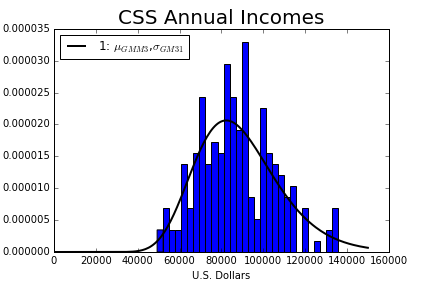

In [43]:
# plot estimated lognormal pdf against histogram from part a

# Plot the histogram of the data
plt.figure()
plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('CSS Annual Incomes', fontsize=20)
plt.xlabel('U.S. Dollars')
plt.ylabel('Percent of Income Observations')

# Plot the estimated GMM PDF for b and c together
dist_incomes = np.linspace(1e-10, 150000, 200)
plt.plot(dist_incomes, lognorm_pdf(dist_incomes, mu_GMM_3, sig_GMM_3, 'None'),
         linewidth=2, color='k', label='1: $\mu_{GMM3}$,$\sigma_{GM31}$')
plt.legend(loc='upper left')

In [38]:
# compare data moments, model moments, and print crit value
print(data_moments3(incomes))
print(model_moments3(mu_GMM_3, sig_GMM_3, 150000))
params3 = np.array([mu_GMM_3, sig_GMM_3])
print(criterion3(params3, incomes, 150000, np.eye(3)))

(0.265, 0.475, 0.26)
(0.2633020938373415, 0.47011926927299197, 0.2582452758234067)
[[ 1.92180502]]


### e. two-step GMM estimator with new three moments

In [50]:
err1_3 = err_vec3(dist_incomes, mu_GMM_3, sig_GMM_3, 150000, False)
VCV2_3 = np.dot(err1_3, err1_3.T) / dist_incomes.shape[0]
print(VCV2_3)
W_hat2_3 = lin.pinv(VCV2_3)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print(W_hat2_3)

[[  11.20517976  -43.77035889    5.42318881]
 [ -43.77035889  170.97845451  -21.184392  ]
 [   5.42318881  -21.184392      2.62476618]]
[[  3.28076718e-04  -1.28155335e-03   1.58785671e-04]
 [ -1.28155335e-03   5.00608214e-03  -6.20258305e-04]
 [  1.58785671e-04  -6.20258305e-04   7.68505898e-05]]


In [53]:
# Estimate new GMM estimator
params_init3_2step = np.array([mu_GMM_3, sig_GMM_3])

gmm_args3_2step = (incomes, 150000, W_hat2_3)
results3_2step = opt.minimize(criterion3, params_init3_2step, args=(gmm_args3_2step),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM_3_2step, sig_GMM_3_2step = results3_2step.x
print('mu_GMM_3_2step=', mu_GMM_3_2step, ' sig_GMM_3_2step=', sig_GMM_3_2step)

mu_GMM_3_2step= 11.3730992781  sig_GMM_3_2step= 0.22780933407


<IPython.core.display.Javascript object>


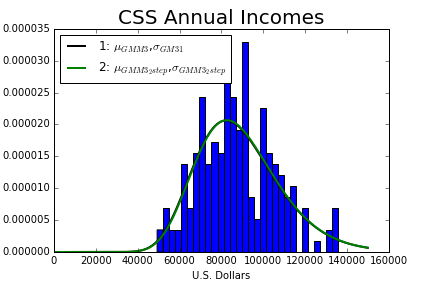

In [54]:
# plot estimated lognormal pdf against histogram from part a and d

# Plot the histogram of the data
plt.figure()
plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title('CSS Annual Incomes', fontsize=20)
plt.xlabel('U.S. Dollars')
plt.ylabel('Percent of Income Observations')

# Plot the estimated GMM PDF for d and e together
dist_incomes = np.linspace(1e-10, 150000, 200)
plt.plot(dist_incomes, lognorm_pdf(dist_incomes, mu_GMM_3, sig_GMM_3, 'None'),
         linewidth=2, color='k', label='1: $\mu_{GMM3}$,$\sigma_{GM31}$')
plt.plot(dist_incomes, lognorm_pdf(dist_incomes, mu_GMM_3_2step, sig_GMM_3_2step, 'None'),
         linewidth=2, color='g', label='2: $\mu_{GMM3_2step}$,$\sigma_{GMM3_2step}$')
plt.legend(loc='upper left')

In [64]:
# compare data moments, model moments, and print newest crit value
params_3_2step = np.array([mu_GMM_3_2step, sig_GMM_3_2step])
GMM_3_2step_crit_value = criterion3(params_3_2step, *gmm_args3_2step)[0][0]

print(data_moments3(incomes))
print(model_moments3(mu_GMM_3_2step, sig_GMM_3_2step, 150000))
print(GMM_3_2step_crit_value)

(0.265, 0.475, 0.26)
(0.258158367093754, 0.4721632681276263, 0.261337084514746)
7.77522498077e-15


### f. Which of the four estimations fits the data best?

In [65]:
print(GMM1_crit_value)
print(GMM2step_crit_value)
print(criterion3(params3, incomes, 150000, np.eye(3)))
print(GMM_3_2step_crit_value)

0.396870224136
2.09338262605e-13
[[ 1.92180502]]
7.77522498077e-15


The estimation from part e fits the best because it has the smallest criterion function value - see four values above.

## Problem 2: Linear regression and GMM

In [89]:
# Load sick data. List(sick_data) for the win this time. 

sick_data = pd.read_csv("sick.txt")
list(sick_data)

['\ufeffsick', 'age', 'children', 'avgtemp_winter']

In [94]:
# First define an error function of the moments using simple difference of the data moments from the model moments.

def err_vec_sick(xvals, b0, b1, b2, b3):

    moms_data = np.array([xvals['\ufeffsick']])
    moms_model = b0 + b1*xvals['age'] + b2*xvals['children'] + b3*xvals['avgtemp_winter']
    moms_model = np.array([moms_model])
    
    err_vec = moms_model - moms_data
    
    return err_vec

In [95]:
# Then define the criterion function using that error function

def criterion_sick(params, *args):
  
    b0, b1, b2, b3 = params
    xvals, W = args
    err = err_vec_sick(xvals, b0, b1, b2, b3)
    crit_val = np.dot(np.dot(err, W), err.T)  
    
    return crit_val

In [97]:
# Now use those functions to estimate the model parameters by GMM

# Initial guesses
b0_init = 0.1
b1_init = 0.1
b2_init = 0.1
b3_init = 0.1
  
params_init_sick = np.array([b0_init, b1_init, b2_init, b3_init]) 
W_hat_sick = np.eye(200)
gmm_args_sick = (sick_data, W_hat_sick)

results_sick = opt.minimize(criterion_sick, params_init_sick, args=(gmm_args_sick), method='L-BFGS-B') 
b0_GMM_sick, b1_GMM_sick, b2_GMM_sick, b3_GMM_sick = results_sick.x

In [99]:
# Print estimated parameters and criterion function value

params_GMM_sick = np.array([b0_GMM_sick, b1_GMM_sick, b2_GMM_sick, b3_GMM_sick])
GMM_value_sick = criterion_sick(params_GMM_sick, *gmm_args_sick)[0][0]

print(b0_GMM_sick, b1_GMM_sick, b2_GMM_sick, b3_GMM_sick)
print(GMM_value_sick)

0.251644406209 0.0129335369146 0.400500297645 -0.00999173496598
0.00182128970496
